# Introduction

The file pseudonymized-data.csv contains 380 responses to 7 different questions. 

The responses are Likert scale marked as 1. Strongly Agree, 2. Agree, 3. Neutral, 4. Disagree, 5. Strongly Disagree.<br>

The questions were asked from members of 13 different  (FOSS) communities that have a unique name and also other unnamed communities that are specified with -1 in the Community column of the Excel file.<br>

The file contains unanswered questions that are specified with a -1 in the relevant question column.
The task is cleaning the data and restructuring it so that it is prepared to be used in a Bayesian model. The model should be implemented leveraging Pymc3 framework so I can use Bayesian inference to test the hypotheses as follows:<br>

• H1: The Coala Community is more lenient than the Linux Kernel Community.<br>

• H2: All communities show either a protective or equitable style of governance for pull requests
(so for each community answers to V29 and V31 are different)<br>

Let's get started with the analysis!

# The import statement
Here I import all the necessary modules for this analysis.

In [1]:
import warnings
import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.stats as st
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator

# Data preparation

I am considering the following steps to cook the raw data:<br>


• Loading the data using pandas library with its read_csv method that returns a DataFrame.<br>

• Deleting the redundant data that won't be used in the modeling.<br>

• Rename the columns appropriately.<br>

• Getting some information about the raw data.<br>

• Filter out the questions which have not been answered and "other" communities.<br>

• Sorting data based on its Community column

In [2]:
# Read the csv file and construct the dataframe 
df = pd.read_csv('pseudonymized-data.csv')

In [3]:
# Let's see the raw data
df

,Unnamed: 0,Community,V27,V28,V29,V30,V31,V32,V33
0,0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,1,Comm.FOSSASIA,5,5,5,5,1,1,1
2,2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
375,382,Comm.OpenSUSE,3,5,5,5,2,1,4
376,383,Comm.ROS,5,5,5,5,2,2,3
377,384,Comm.Plone,4,5,5,4,4,4,3
378,385,Comm.Linux_Kernel,-1,-1,-1,-1,-1,-1,-1


In [4]:
# Get rid of the "Unnamed: 0" column.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,Community,V27,V28,V29,V30,V31,V32,V33
0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,Comm.FOSSASIA,5,5,5,5,1,1,1
2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
375,Comm.OpenSUSE,3,5,5,5,2,1,4
376,Comm.ROS,5,5,5,5,2,2,3
377,Comm.Plone,4,5,5,4,4,4,3
378,Comm.Linux_Kernel,-1,-1,-1,-1,-1,-1,-1


In [5]:
# Drop out the redundant data which I won't use in my inference.
df = df.drop(['V27', 'V28', 'V30', 'V32'], axis=1)
df

,Community,V29,V31,V33
0,Comm.FOSSASIA,4,1,1
1,Comm.FOSSASIA,5,1,1
2,Comm.FOSSASIA,-1,-1,-1
3,Comm.FOSSASIA,-1,-1,-1
4,Comm.FOSSASIA,-1,-1,-1
...,...,...,...,...
375,Comm.OpenSUSE,5,2,4
376,Comm.ROS,5,2,3
377,Comm.Plone,5,4,3
378,Comm.Linux_Kernel,-1,-1,-1


In [6]:
# Rename the columns for making it nicer
df = df.rename(columns={'V29':'Protective', 'V31':'Equitable', 'V33':'Lenient'})
df

,Community,Protective,Equitable,Lenient
0,Comm.FOSSASIA,4,1,1
1,Comm.FOSSASIA,5,1,1
2,Comm.FOSSASIA,-1,-1,-1
3,Comm.FOSSASIA,-1,-1,-1
4,Comm.FOSSASIA,-1,-1,-1
...,...,...,...,...
375,Comm.OpenSUSE,5,2,4
376,Comm.ROS,5,2,3
377,Comm.Plone,5,4,3
378,Comm.Linux_Kernel,-1,-1,-1


In [7]:
# Getting some information about the raw data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Community   380 non-null    object
 1   Protective  380 non-null    int64 
 2   Equitable   380 non-null    int64 
 3   Lenient     380 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.0+ KB


It tells that there is not any null value in the DataFrame which is good!
The type of Community column is object then I should be careful when operating on it.<br>

Let's filter out those questions that have not been answered and ’other’ communities.<br>
An object is a string in pandas so I use '-1' instead of -1 to filter out communities that are not in the list of communities in question.

In [8]:
data = df.drop(df[(df.Community == '-1') | (df.Protective == -1) | 
           (df.Equitable == -1) | (df.Lenient == -1)].index)

# Sort data based on its Community column
data = data.sort_values(by=['Community'])
data.Community.unique() # 13 communities in total

array(['Comm.Apache', 'Comm.Coala', 'Comm.FOSSASIA', 'Comm.Linux_Kernel',
       'Comm.Mozilla', 'Comm.NodeJS', 'Comm.Odoo', 'Comm.OpenGenus',
       'Comm.OpenSUSE', 'Comm.Plone', 'Comm.ROS', 'Comm.ReactJS',
       'Comm.jQuery'], dtype=object)

As you see there are only 167 data points for each quantitative question after data cleaning. That is some interviewees did not answer and some communities are not in our interested communities (in total, 213 dropped data points).<br> 
I now extract the desired data from the DataFrame to using later in my model.

In [9]:
Apache_P = data[(data.Community == 'Comm.Apache')].Protective
Apache_E = data[(data.Community == 'Comm.Apache')].Equitable
Apache_L = data[(data.Community == 'Comm.Apache')].Lenient

Coala_P = data[(data.Community == 'Comm.Coala')].Protective
Coala_E = data[(data.Community == 'Comm.Coala')].Equitable
Coala_L = data[(data.Community == 'Comm.Coala')].Lenient

FOSSASIA_P = data[(data.Community == 'Comm.FOSSASIA')].Protective
FOSSASIA_E = data[(data.Community == 'Comm.FOSSASIA')].Equitable
FOSSASIA_L = data[(data.Community == 'Comm.FOSSASIA')].Lenient

Linux_Kernel_P = data[(data.Community == 'Comm.Linux_Kernel')].Protective
Linux_Kernel_E = data[(data.Community == 'Comm.Linux_Kernel')].Equitable
Linux_Kernel_L = data[(data.Community == 'Comm.Linux_Kernel')].Lenient

Mozilla_P = data[(data.Community == 'Comm.Mozilla')].Protective
Mozilla_E = data[(data.Community == 'Comm.Mozilla')].Equitable
Mozilla_L = data[(data.Community == 'Comm.Mozilla')].Lenient

NodeJS_P = data[(data.Community == 'Comm.NodeJS')].Protective
NodeJS_E = data[(data.Community == 'Comm.NodeJS')].Equitable
NodeJS_L = data[(data.Community == 'Comm.NodeJS')].Lenient

Odoo_P = data[(data.Community == 'Comm.Odoo')].Protective
Odoo_E = data[(data.Community == 'Comm.Odoo')].Equitable
Odoo_L = data[(data.Community == 'Comm.Odoo')].Lenient

OpenGenus_P = data[(data.Community == 'Comm.OpenGenus')].Protective
OpenGenus_E = data[(data.Community == 'Comm.OpenGenus')].Equitable
OpenGenus_L = data[(data.Community == 'Comm.OpenGenus')].Lenient

OpenSUSE_P = data[(data.Community == 'Comm.OpenSUSE')].Protective
OpenSUSE_E = data[(data.Community == 'Comm.OpenSUSE')].Equitable
OpenSUSE_L = data[(data.Community == 'Comm.OpenSUSE')].Lenient

Plone_P = data[(data.Community == 'Comm.Plone')].Protective
Plone_E = data[(data.Community == 'Comm.Plone')].Equitable
Plone_L = data[(data.Community == 'Comm.Plone')].Lenient

ROS_P = data[(data.Community == 'Comm.ROS')].Protective
ROS_E = data[(data.Community == 'Comm.ROS')].Equitable
ROS_L = data[(data.Community == 'Comm.ROS')].Lenient

ReactJS_P = data[(data.Community == 'Comm.ReactJS')].Protective
ReactJS_E = data[(data.Community == 'Comm.ReactJS')].Equitable
ReactJS_L = data[(data.Community == 'Comm.ReactJS')].Lenient

jQuery_P = data[(data.Community == 'Comm.jQuery')].Protective
jQuery_E = data[(data.Community == 'Comm.jQuery')].Equitable
jQuery_L = data[(data.Community == 'Comm.jQuery')].Lenient

# Data Plots
Before implementing the model it is always a good idea to plot the data to understand whether they are normally distributed.<br>

All plots are binned into 5 bins since there is 5 point Likert scale namely, 

1. Strongly Agree, 2. Agree, 3. Neutral, 4. Disagree, 5. Strongly Disagree.


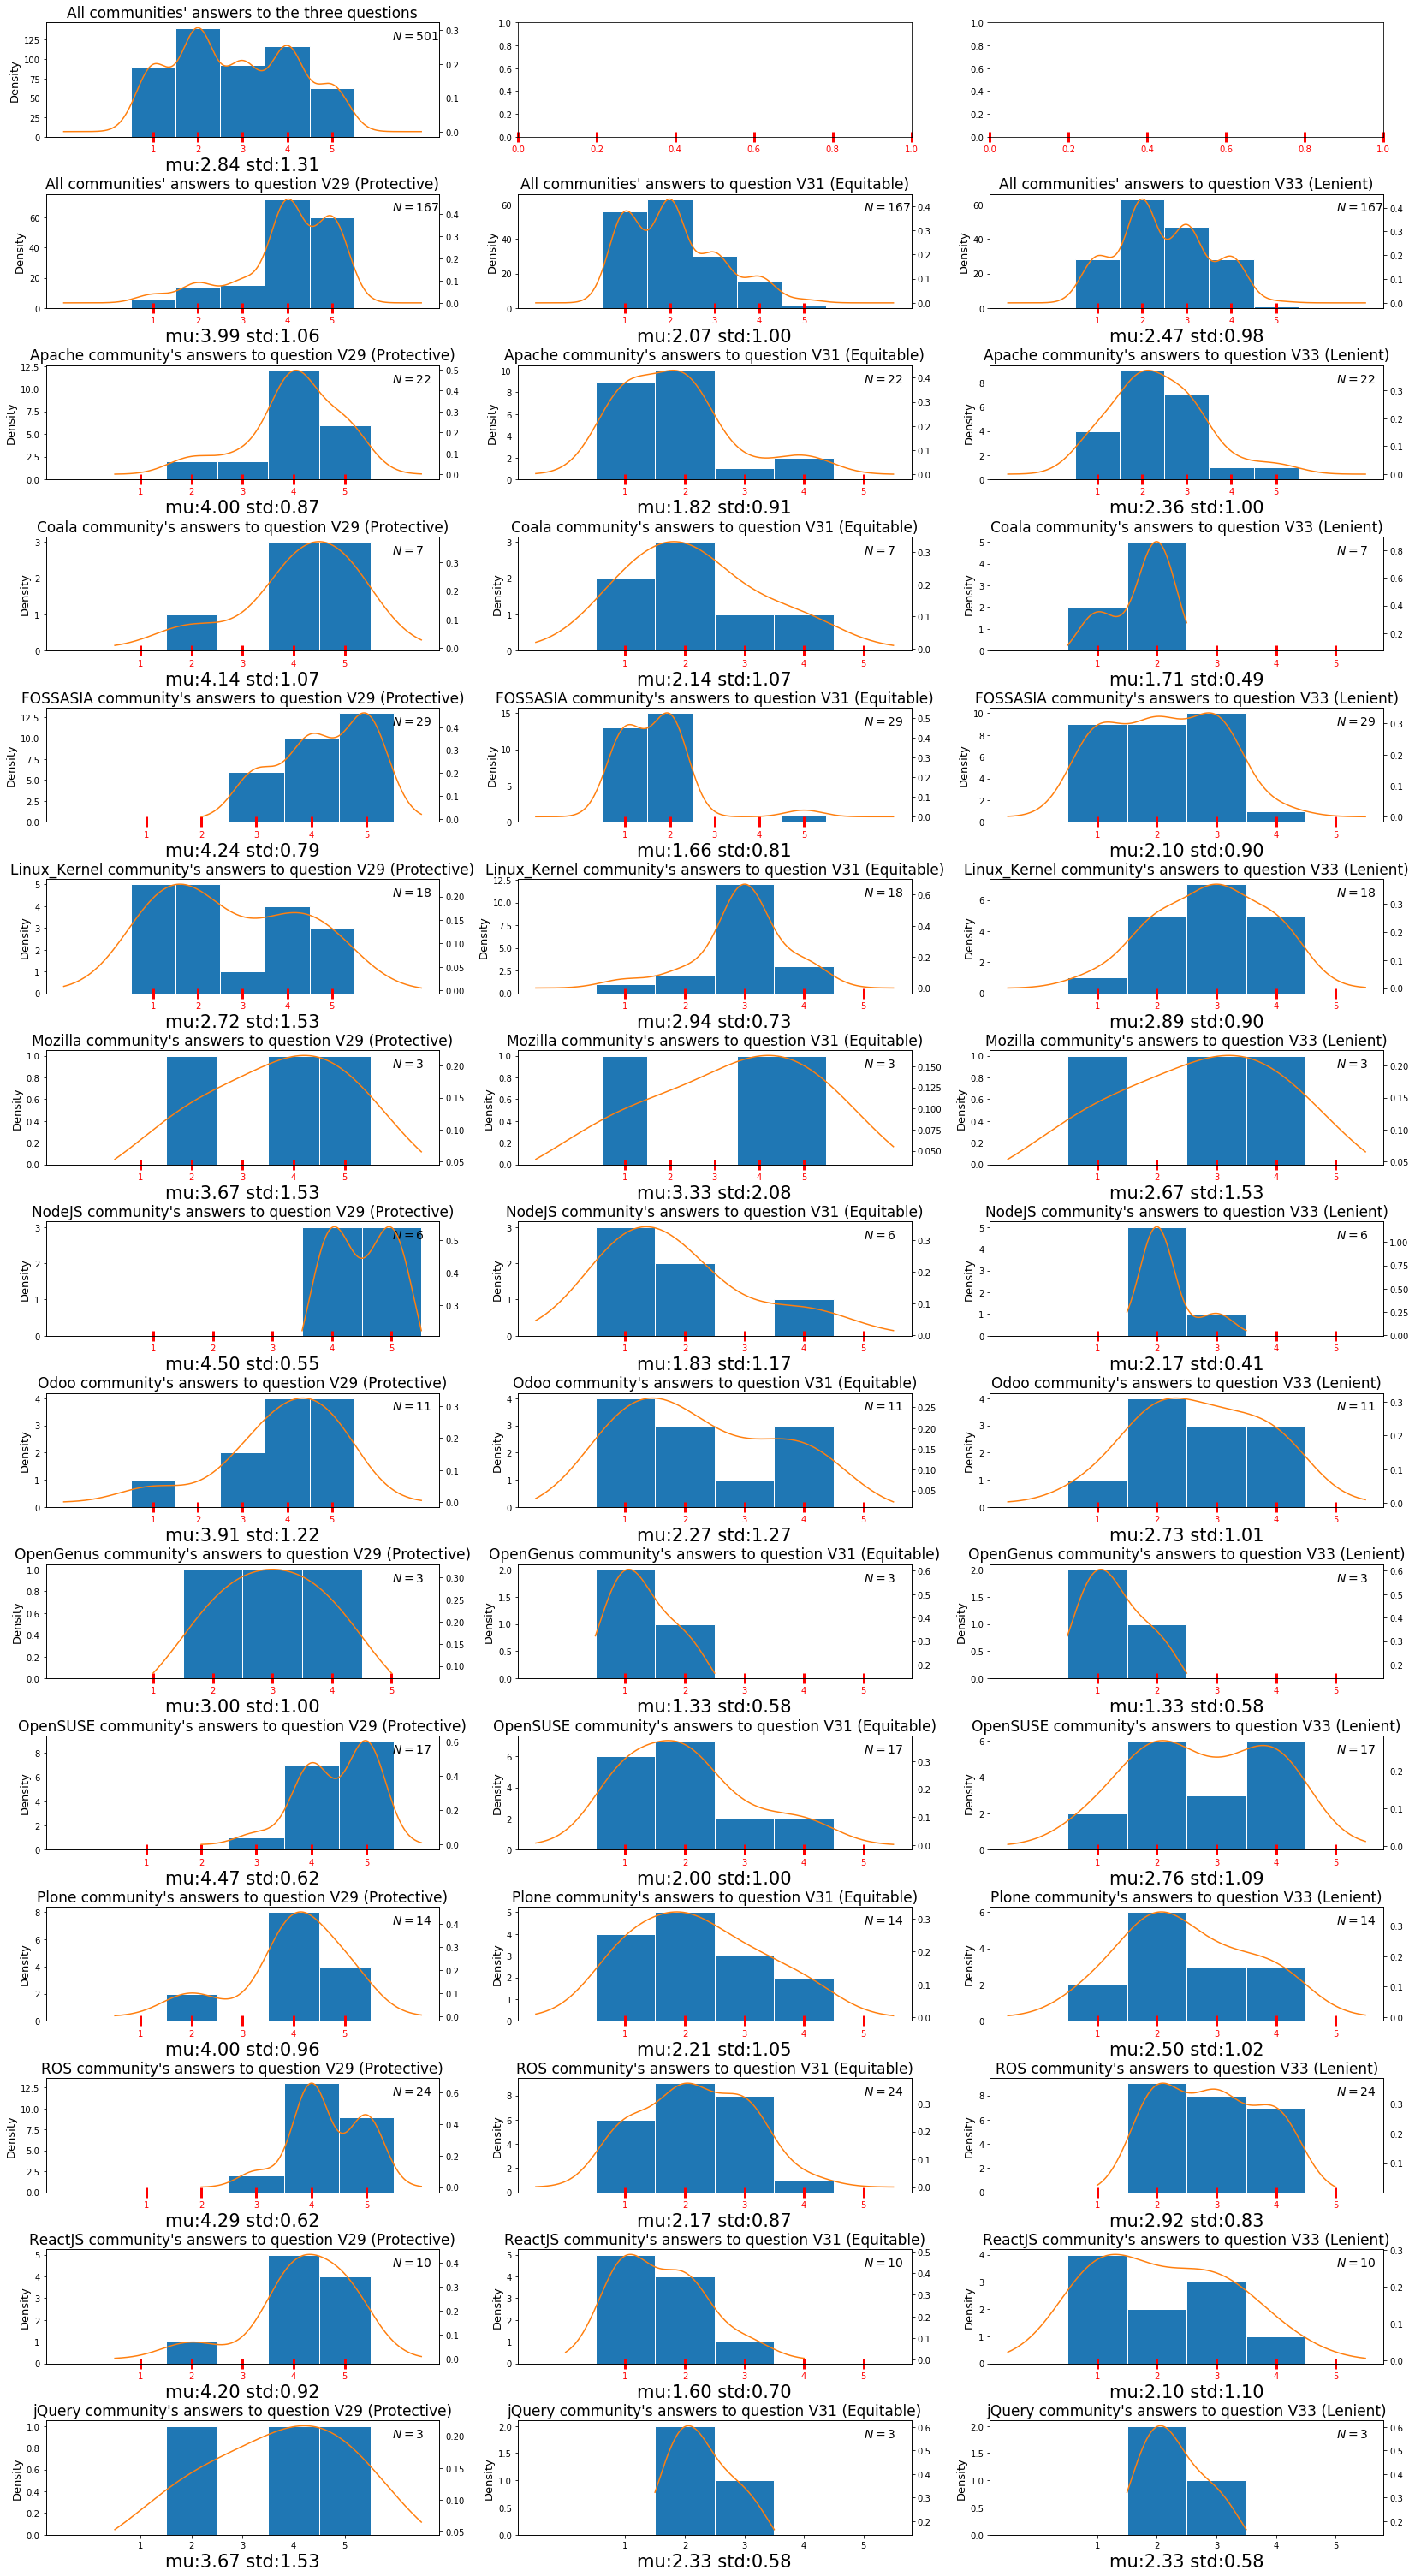

In [10]:
# Helper funtion to plot data
def plot_response(ax, data, label):
    data.plot.hist(ax=ax, bins=[0, 1, 2, 3, 4, 5, 6], sharex=False, align='left', edgecolor='w')
    mean = data.mean()
    std = data.std()
    ax.text(0.88, 0.85, r'$N='+str(len(data))+'$', transform=ax.transAxes, fontsize=14)    
    ax.xaxis.set_major_locator(FixedLocator([1,2,3,4,5]))
    ax.xaxis.set_minor_locator(FixedLocator([1,2,3,4,5]))
    ax.set_title(label, fontdict={'fontsize':17})    
    ax.set_ylabel("", fontdict={'fontsize':13})
    ax.set_xlabel(f"mu:{mean:.2f} std:{std:.2f}", fontdict={'fontsize':21})
    data.plot.kde(ax=ax, secondary_y=True, sharex=False)
    
fig, ax = plt.subplots(15,3, figsize=(28,54))
fig.subplots_adjust(hspace = 0.5) 

plot_response(ax[0,0], pd.concat([data.Protective, data.Equitable, data.Lenient]), "All communities' answers to the three questions")

plot_response(ax[1,0], data.Protective, "All communities' answers to question V29 (Protective)")
plot_response(ax[1,1], data.Equitable, "All communities' answers to question V31 (Equitable)")
plot_response(ax[1,2], data.Lenient, "All communities' answers to question V33 (Lenient)")

plot_response(ax[2,0], Apache_P, "Apache community's answers to question V29 (Protective)")
plot_response(ax[2,1], Apache_E, "Apache community's answers to question V31 (Equitable)")
plot_response(ax[2,2], Apache_L, "Apache community's answers to question V33 (Lenient)")

plot_response(ax[3,0], Coala_P, "Coala community's answers to question V29 (Protective)")
plot_response(ax[3,1], Coala_E, "Coala community's answers to question V31 (Equitable)")
plot_response(ax[3,2], Coala_L, "Coala community's answers to question V33 (Lenient)")

plot_response(ax[4,0], FOSSASIA_P, "FOSSASIA community's answers to question V29 (Protective)")
plot_response(ax[4,1], FOSSASIA_E, "FOSSASIA community's answers to question V31 (Equitable)")
plot_response(ax[4,2], FOSSASIA_L, "FOSSASIA community's answers to question V33 (Lenient)")

plot_response(ax[5,0], Linux_Kernel_P, "Linux_Kernel community's answers to question V29 (Protective)")
plot_response(ax[5,1], Linux_Kernel_E, "Linux_Kernel community's answers to question V31 (Equitable)")
plot_response(ax[5,2], Linux_Kernel_L, "Linux_Kernel community's answers to question V33 (Lenient)")

plot_response(ax[6,0], Mozilla_P, "Mozilla community's answers to question V29 (Protective)")
plot_response(ax[6,1], Mozilla_E, "Mozilla community's answers to question V31 (Equitable)")
plot_response(ax[6,2], Mozilla_L, "Mozilla community's answers to question V33 (Lenient)")

plot_response(ax[7,0], NodeJS_P, "NodeJS community's answers to question V29 (Protective)")
plot_response(ax[7,1], NodeJS_E, "NodeJS community's answers to question V31 (Equitable)")
plot_response(ax[7,2], NodeJS_L, "NodeJS community's answers to question V33 (Lenient)")

plot_response(ax[8,0], Odoo_P, "Odoo community's answers to question V29 (Protective)")
plot_response(ax[8,1], Odoo_E, "Odoo community's answers to question V31 (Equitable)")
plot_response(ax[8,2], Odoo_L, "Odoo community's answers to question V33 (Lenient)")

plot_response(ax[9,0], OpenGenus_P, "OpenGenus community's answers to question V29 (Protective)")
plot_response(ax[9,1], OpenGenus_E, "OpenGenus community's answers to question V31 (Equitable)")
plot_response(ax[9,2], OpenGenus_L, "OpenGenus community's answers to question V33 (Lenient)")

plot_response(ax[10,0], OpenSUSE_P, "OpenSUSE community's answers to question V29 (Protective)")
plot_response(ax[10,1], OpenSUSE_E, "OpenSUSE community's answers to question V31 (Equitable)")
plot_response(ax[10,2], OpenSUSE_L, "OpenSUSE community's answers to question V33 (Lenient)")

plot_response(ax[11,0], Plone_P, "Plone community's answers to question V29 (Protective)")
plot_response(ax[11,1], Plone_E, "Plone community's answers to question V31 (Equitable)")
plot_response(ax[11,2], Plone_L, "Plone community's answers to question V33 (Lenient)")

plot_response(ax[12,0], ROS_P, "ROS community's answers to question V29 (Protective)")
plot_response(ax[12,1], ROS_E, "ROS community's answers to question V31 (Equitable)")
plot_response(ax[12,2], ROS_L, "ROS community's answers to question V33 (Lenient)")

plot_response(ax[13,0], ReactJS_P, "ReactJS community's answers to question V29 (Protective)")
plot_response(ax[13,1], ReactJS_E, "ReactJS community's answers to question V31 (Equitable)")
plot_response(ax[13,2], ReactJS_L, "ReactJS community's answers to question V33 (Lenient)")

plot_response(ax[14,0], jQuery_P, "jQuery community's answers to question V29 (Protective)")
plot_response(ax[14,1], jQuery_E, "jQuery community's answers to question V31 (Equitable)")
plot_response(ax[14,2], jQuery_L, "jQuery community's answers to question V33 (Lenient)")

for i in range(14):
    for j in range(3):
        ax[i,j].xaxis.label.set_visible(True)
        ax[i,j].tick_params(axis='x', colors='red', direction='inout', 
                            length=12, width=3, top=False, labelbottom=True)        

As you may have realized, the data is not normal in fact. Roughly half of the above plots are illustrating either bimodal distributions or multimodal distributions.<br>

However, I suppose the data is normally distributed. 
Consequently, I will select a **large standard deviation** for the prior.<br>

The following diagram illustrates the model that I want to implement.

# Model diagram
<!-- <figure>  -->
<!--     <img src="model.png" alt="Figure 17.2" width="500px" />  -->
<!--     <figcaption style="text-align: center; font-size: 10px"> -->
            Source: Figure 16.11. John K. Kruschke. Doing Bayesian Data Analysis. (2014).
<!--     </figcaption> -->
<!-- </figure> -->

![title](model.png)

# Model implementation

In [11]:
# Prepare parameters
y = pd.concat([data.Protective, data.Equitable, data.Lenient]).to_numpy()
mu_y = np.mean(y)
sigma_y = np.std(y)

# Prepare observed data to the likelihood function
y_joint = [Apache_P, Coala_P, FOSSASIA_P, Linux_Kernel_P, Mozilla_P, NodeJS_P, Odoo_P, OpenGenus_P, 
           OpenSUSE_P, Plone_P, ROS_P, ReactJS_P, jQuery_P,
           Apache_E, Coala_E, FOSSASIA_E, Linux_Kernel_E, Mozilla_E, NodeJS_E, Odoo_E, OpenGenus_E, 
           OpenSUSE_E, Plone_E, ROS_E, ReactJS_E, jQuery_E,
           Apache_L, Coala_L, FOSSASIA_L, Linux_Kernel_L, Mozilla_L, NodeJS_L, Odoo_L, OpenGenus_L, 
           OpenSUSE_L, Plone_L, ROS_L, ReactJS_L, jQuery_L]
len(y_joint)

39

In [12]:
with pm.Model() as model_ta:
    # Priors
    sigma = pm.Uniform('sigma',lower=1/1000,upper=sigma_y*1000,shape=39)
    mu = pm.Normal('mu',mu=mu_y,sigma=sigma_y*150,shape=39)
    nu = pm.Exponential('nu',lam=1/29)
    # Likelihood
    [pm.StudentT(f'obs_{i}', nu=nu+1, mu=mu[i], sigma=sigma[i], observed=y_joint[i]) for i in range(39)]
    # For ploting with ease     
    pm.Deterministic('log10_nu',np.log10(nu))
    pm.Deterministic('log10_sigma',np.log10(sigma))        

I used a normal distribution('mu') with a mean value exactly the same as the real mean of the data (mu_y), and a standard deviation value 150 times larger than the standard deviation of the data (sigma_y) for the mean parameter of the StudentT distribution. For the scale parameter of the StudentT distribution, I used a very large uniform prior ('sigma') from 1/1000 (L in the model diagram) to (H in the model diagram) 1000 times the standard deviation of the data (sigma_y).
The model utilizes the StudentT distribution for describing noise in the data and handle the outliers (if any). A Uniform ('sigma'), Normal ('mu') and Exponential distribution ('nu') are used for the prior distributions on parameters of the StudentT distribution (I.e. scale, mean and normality respectively). The Uniform distribution is applied to the **scale parameter**, Normal distribution to the mean parameter and Exponential distribution (K in the model diagram) to the normality parameter since I needed a prior on the normality parameter that gave equal opportunity to small values (less than 30) and larger values (greater than 30). The normality parameter is shifted by one because the Exponential distribution ranges from 0 to infinity but the normality parameter is required to be greater than one in this model (V' +1 in the model diagram). It controls the heaviness of the tails.
The parameters of the normal distribution('mu') are set to be noncommittal by setting its mean (M in the model diagram) to the actual mean of the data (mu_y) and its standard deviation (S in the model diagram) to 150 times larger than the standard deviation of the data (sigma_y) as I stated earlier. The parameters of sigma (L and H in the model diagram) are chosen in a way that put a broad uniform distribution directly on the **scale parameter** of the likelihood function. The **scale parameter** is bold to make it explicit that it is not the same as standard deviation.

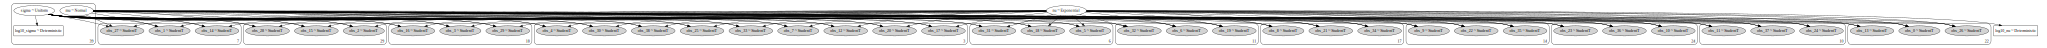

In [13]:
# Plot the digraph of the model
pm.model_to_graphviz(model_ta)

# Sampling posterior
I draw two chains of 15000 samples from the posterior using **NUTS** which is the default sampler in pymc3. No-U-Turn Sampler (NUTS) is a self-tuning variant of the Hamiltonian Monte Carlo algorithm (HMC). It works well on high dimensional and handles correlations among the variables much better than the standard Metropolis algorithm.  Unlike the Gibbs sampler, it does not require a conjugate prior.

In [14]:
with model_ta:
    trace_ta30k=pm.sample(draws=15000, chains=2, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [nu, mu, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 31000/31000 [13:25<00:00, 38.49draws/s]
The acceptance probability does not match the target. It is 0.9279725496769532, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


The warning about acceptance probability is not a big deal since the actual acceptance rate is higher than the target. (described [here](https://discourse.pymc.io/t/warning-when-nuts-probability-is-greater-than-acceptance-level/594
)) <br>
But the second one is important. It basically tells that the effective sample size for some parameters is less relative to the other parameters with respect to the sample size.<br>
Let's look at the trace plot.

# Trace plots

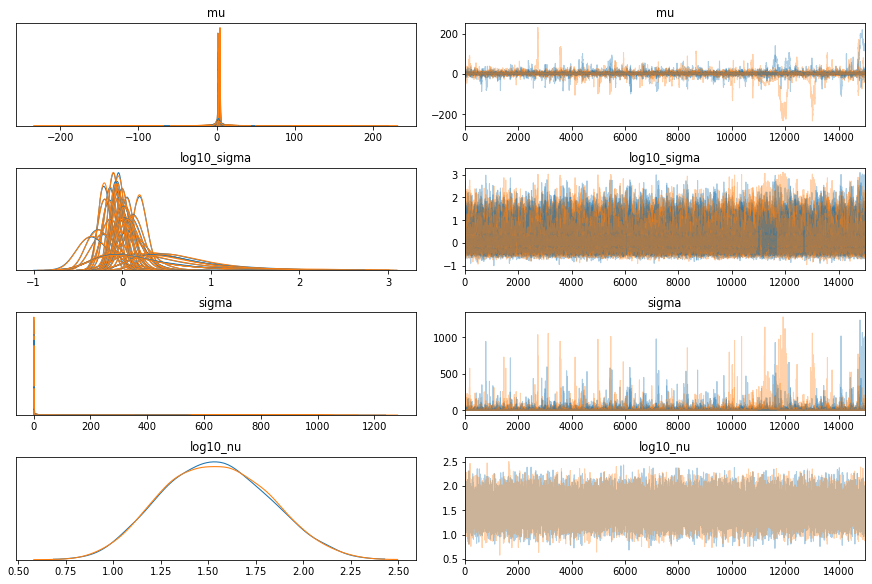

In [15]:
warnings.simplefilter('ignore', UserWarning) # Avoid printing the annoying user warning, likely a bug
pm.traceplot(trace_ta30k, var_names=['mu', 'log10_sigma', 'sigma', 'log10_nu']);

There are obviously **orphaned chains for 'mu'** that have somehow settled into **unusual regions of parameter space**. Simply put, the chains are not representative of the posterior distribution as they did not overlap each other. Since I will make my inference based on the mu, I cannot move on and have to improve the convergence of the chains.
The chains will coverage as sample size approach to infinity (n → ∞).
Therefore, the first thing I can do is, increasing the sample size but I am going to give up at some point. Let's try 30000 draws for each chain and set the tune (burn-in) to 15000 and see if the chains overlap. I increase the burn-in up to 15000 since the first 15000 samples cannot be used in the inference as shown in the trace plot of 'mu' (top right).

In [16]:
with model_ta:
    trace_ta60k=pm.sample(draws=30000, chains=2, cores=4, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [nu, mu, sigma]
Sampling 2 chains, 113 divergences: 100%|██████████| 90000/90000 [51:05<00:00, 29.36draws/s]
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5372787711509657, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5459018182109643, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


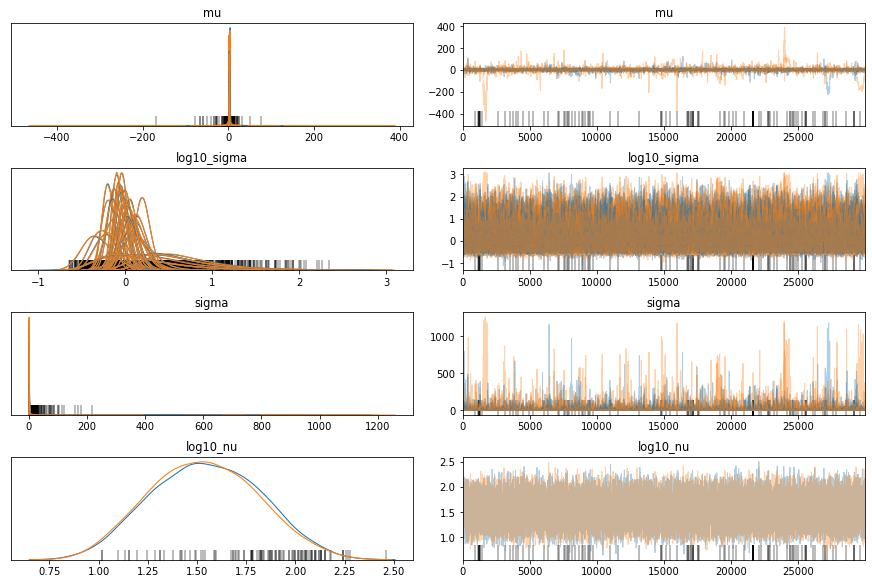

In [17]:
pm.traceplot(trace_ta60k, var_names=['mu', 'log10_sigma', 'sigma', 'log10_nu']);

It got worse! The chains did not overlap. Even though the sampler drew 60000 besides 30000 (burn-in period) samples from the posterior! Moreover, there are a lot of divergences so that the below of the plots looks like a barcode. Each black line indicates a divergent point. Of course, I can increase the target_accept rate e.g. 0.95 to prevent divergences. But it is not only the issue. **The chains are still orphaned**. I repudiate that with more sample size and setting high target_accept rate, the chains eventually coverage. Here at least not till **1000000 sample size**. (I tried to sample 2 chain of 500000 but still, it failed. I put a screenshot below) The problem should be somewhere else.<br>

![title](1M.png)

It is enigmatic that the trace plot of 'mu' at some step shows a sampled parameter value that is far away from the sampled parameter values where the chains overlap! And it happens even after 60000 steps. Therefore, with respect to this model parameterization, the chains still won't get coverage even with more sample size.
I have to somehow trace the model to see what went wrong. In other words, reconsidering the priors. It going to be complex and boring but I will try my best.<br> 

The model has three prior and the likelihood. Let's consider one sampled value for each of the priors and try to see the result. I below provide a handwritten picture helping me to understand better. To sample from the posterior 'mu', sampler first needs to sample from the three priors (since they are the parameter of the likelihood) to be able to estimate the Maximum likelihood which is a StudentT distribution here and eventually multiply the sampled value of the prior 'mu' by the estimated value of the likelihood function to reveal the value of the target distribution 'mu' whether to accept by HMC algorithm (NUTS version).<br>

Since the 'nu' does not affect so much on the posterior, let's fix it to 30. The values and boundaries in the below picture are taken from the model. Once those values are known, the StudentT distribution which is nothing but a function (likelihood function), can compute the probability of getting the observed data given that StudentT distribution. Assume it observed [2,4,1,3,5] (all observed data are among the [1,2,3,4,5]). It returns the most likely value. Let's compute it!

In [18]:
print(mu_y, sigma_y, sep='\n')

2.844311377245509
1.3070179734359166


![title](handwritten.jpg)

As I made it explicit in the above picture, assume the sampled values are 10 and 21 for 'mu' and 'sigma' respectively. I now plot the StudenT distribution given those parameters.

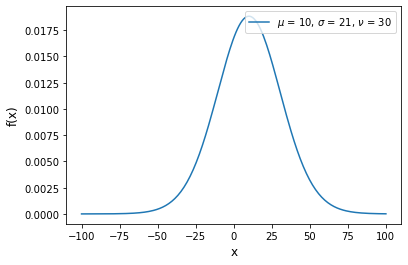

In [19]:
x = np.linspace(-100, 100, 200)
pdf = st.t.pdf(x, df=30, loc=10, scale=21) # df is nu, loc is mu, scale is sigma 
plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}, $\nu$ = {}'.format(10, 21, 30))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

Given the observed data lets calculate the probability of them.

In [20]:
st.t.pdf([2,4,1,3,5], 30, loc=10, scale=21)

array([0.01748183, 0.01806259, 0.01713895, 0.01779044, 0.01829633])

The most probable value is 5. **The parameter space approximately ranges from -50 to 50.** The larger sampled value from the uniform distribution the wider parameter space for 'mu' (and it is the case most of the time since it is a uniform distribution from 0.001 to 1300). Therefore, any value within this range can be proposed. NUTS tends to move toward the most likely values (near to the mean), but it is still possible to have the values within the range! So if I restrict the parameter space it won't get too far away from the mean and hence parameter value in the chains remain close to each other. I can do that by setting the lower and upper parameters of the uniform distribution much smaller so that the sampled value from it will be a small value. Consequently, the StudentT distribution will be much narrower. Assume that I did that and the new sampled value from the uniform distribution is 3. The below plot illustrates it. The orange curve is the last StudentT distribution with scale parameter 21 and the blue one with 3.

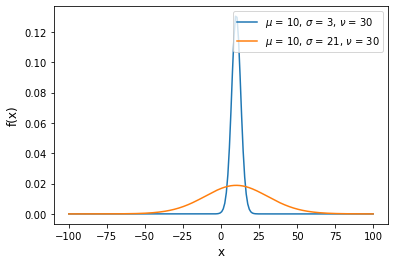

In [21]:
x = np.linspace(-100, 100, 200)
mus = [10, 10]
sigmas = [3, 21]
dfs = [30,30]
for mu, sigma, df in zip(mus, sigmas, dfs):
    pdf = st.t.pdf(x, df, loc=mu, scale=sigma)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}, $\nu$ = {}'.format(mu, sigma, df))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

As you see the blue one distribution is more appropriate in our case.<br>

Now I implement a new model that is exactly the same as the last model but now the prior uniform distribution range **from 0.1 to 5.0**.

In [22]:
with pm.Model() as model_tb:
    # Priors
    sigma = pm.Uniform('sigma',lower=0.1,upper=5.0,shape=39)
    mu = pm.Normal('mu',mu=mu_y,sigma=sigma_y*150,shape=39)
    nu = pm.Exponential('nu',lam=1/29)
    # Likelihood
    [pm.StudentT(f'obs_{i}', nu=nu+1, mu=mu[i], sigma=sigma[i], observed=y_joint[i]) for i in range(39)]
    # For ploting normality with ease     
    pm.Deterministic('log10_nu',np.log10(nu))
    pm.Deterministic('log10_sigma',np.log10(sigma))        

I draw four chains of 70000 samples from the posterior (again using NUTS).

In [23]:
with model_tb: 
    trace_tb280k = pm.sample(70000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, mu, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 282000/282000 [54:35<00:00, 86.09draws/s]  


It sounds good. Let's look at the trace plots.

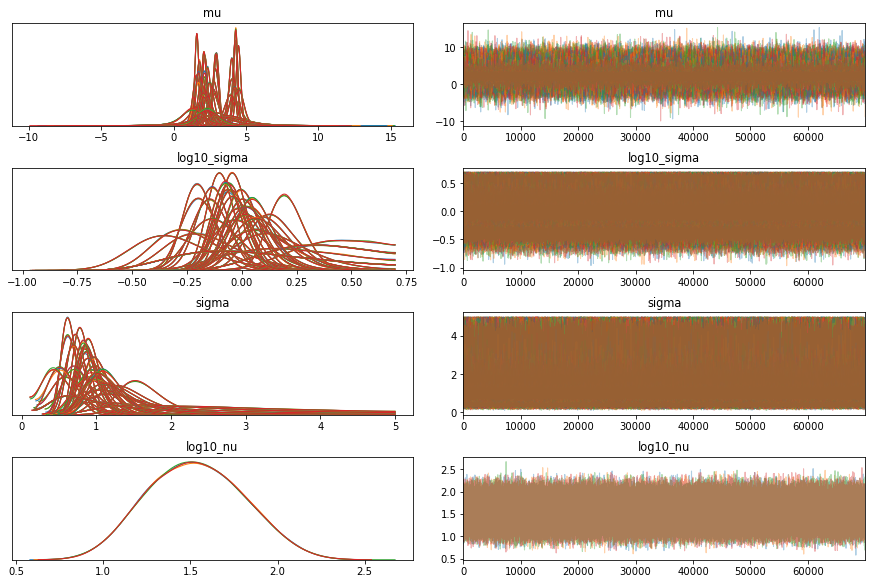

In [24]:
pm.traceplot(trace_tb280k, var_names=['mu', 'log10_sigma', 'sigma', 'log10_nu']);

Now everything is fine. **No divergence, no orphaned chains**.<br>

It is time for checking the autocorrelation. I set the combined parameter True for combining the four chains into a single chain so that it occupies less space.

# Autocorrelation plots

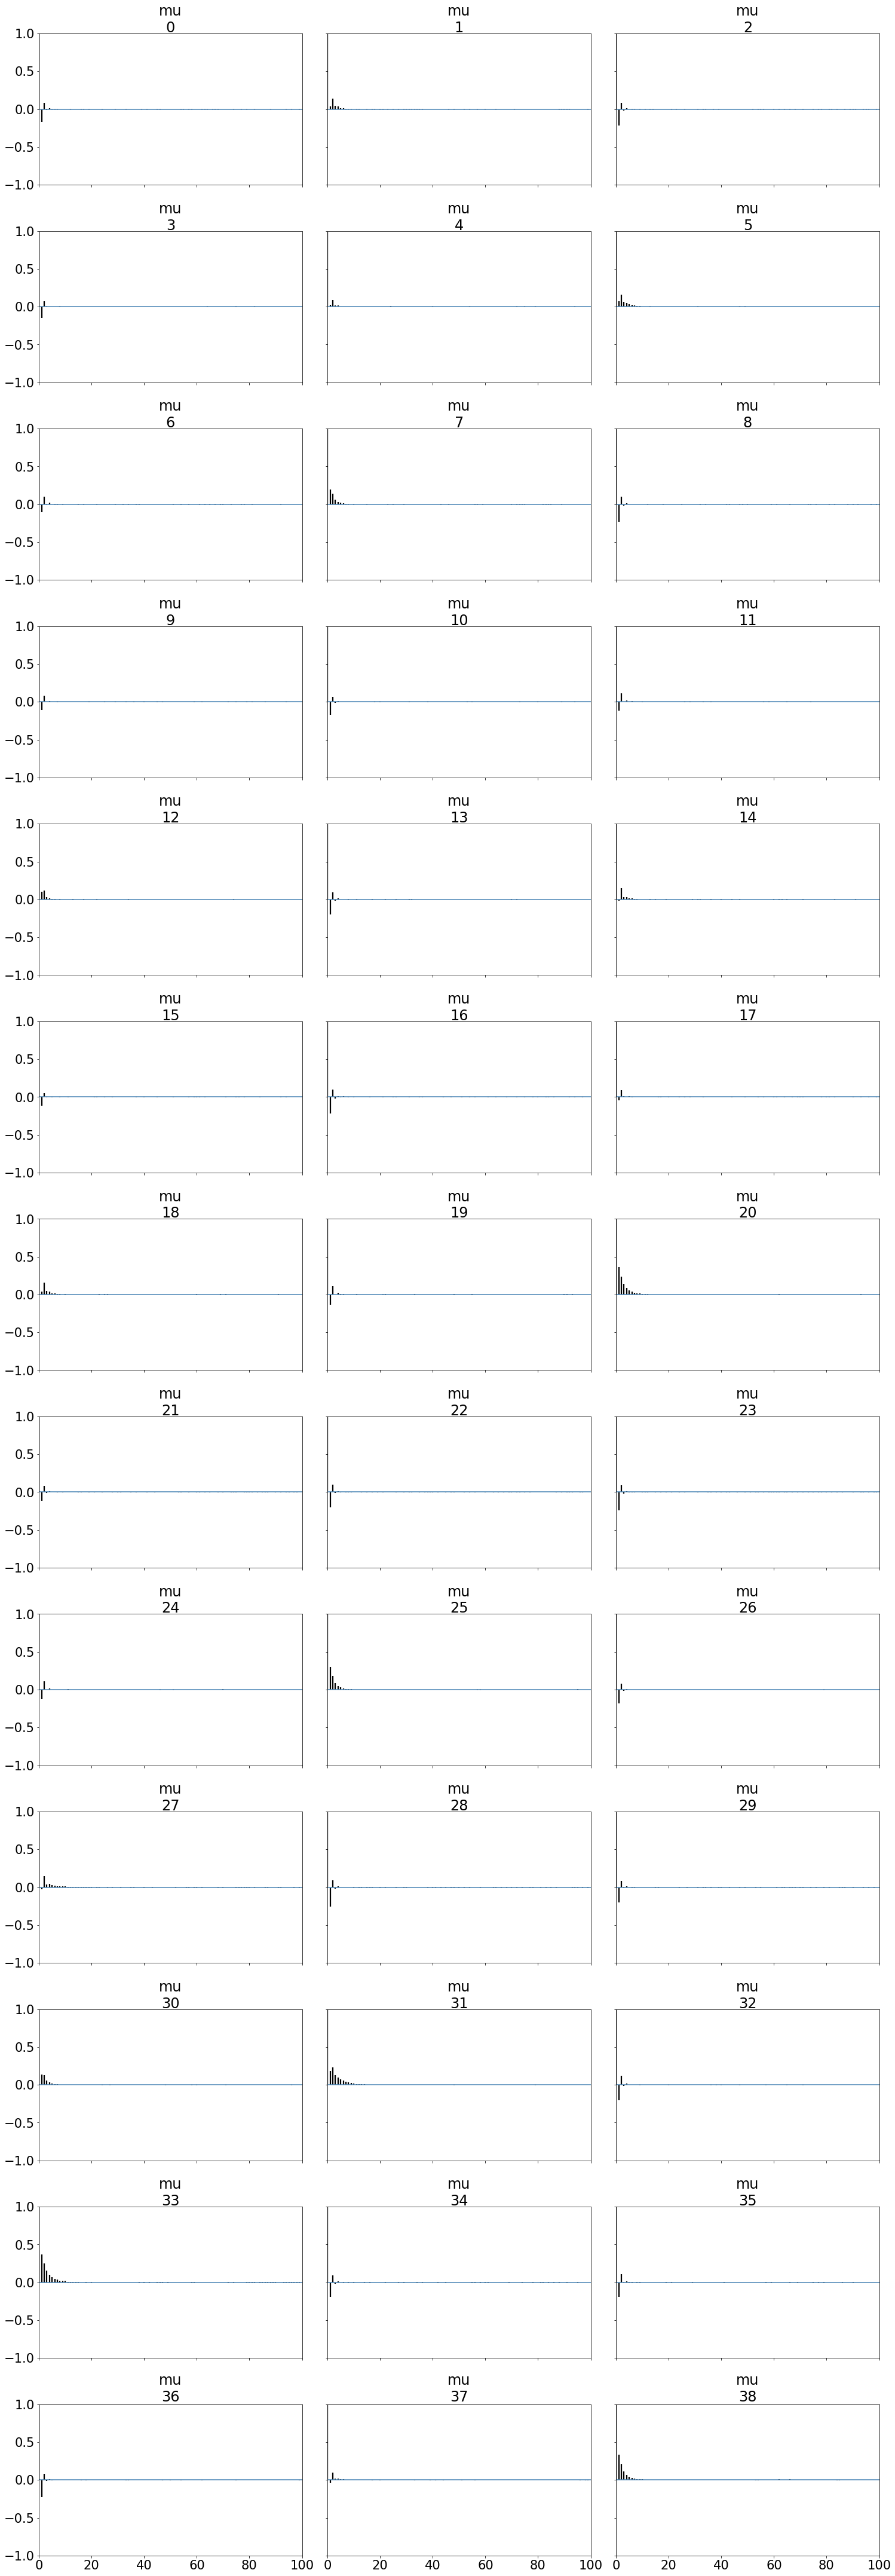

In [25]:
pm.autocorrplot(trace_tb280k, var_names=['mu'], combined=True, textsize=21);

As you can see above, autocorrelation is about zero for all chains which indicates the chains are random. Exactly what I want. I check the autocorrelation for 'sigma' and 'nu' too.

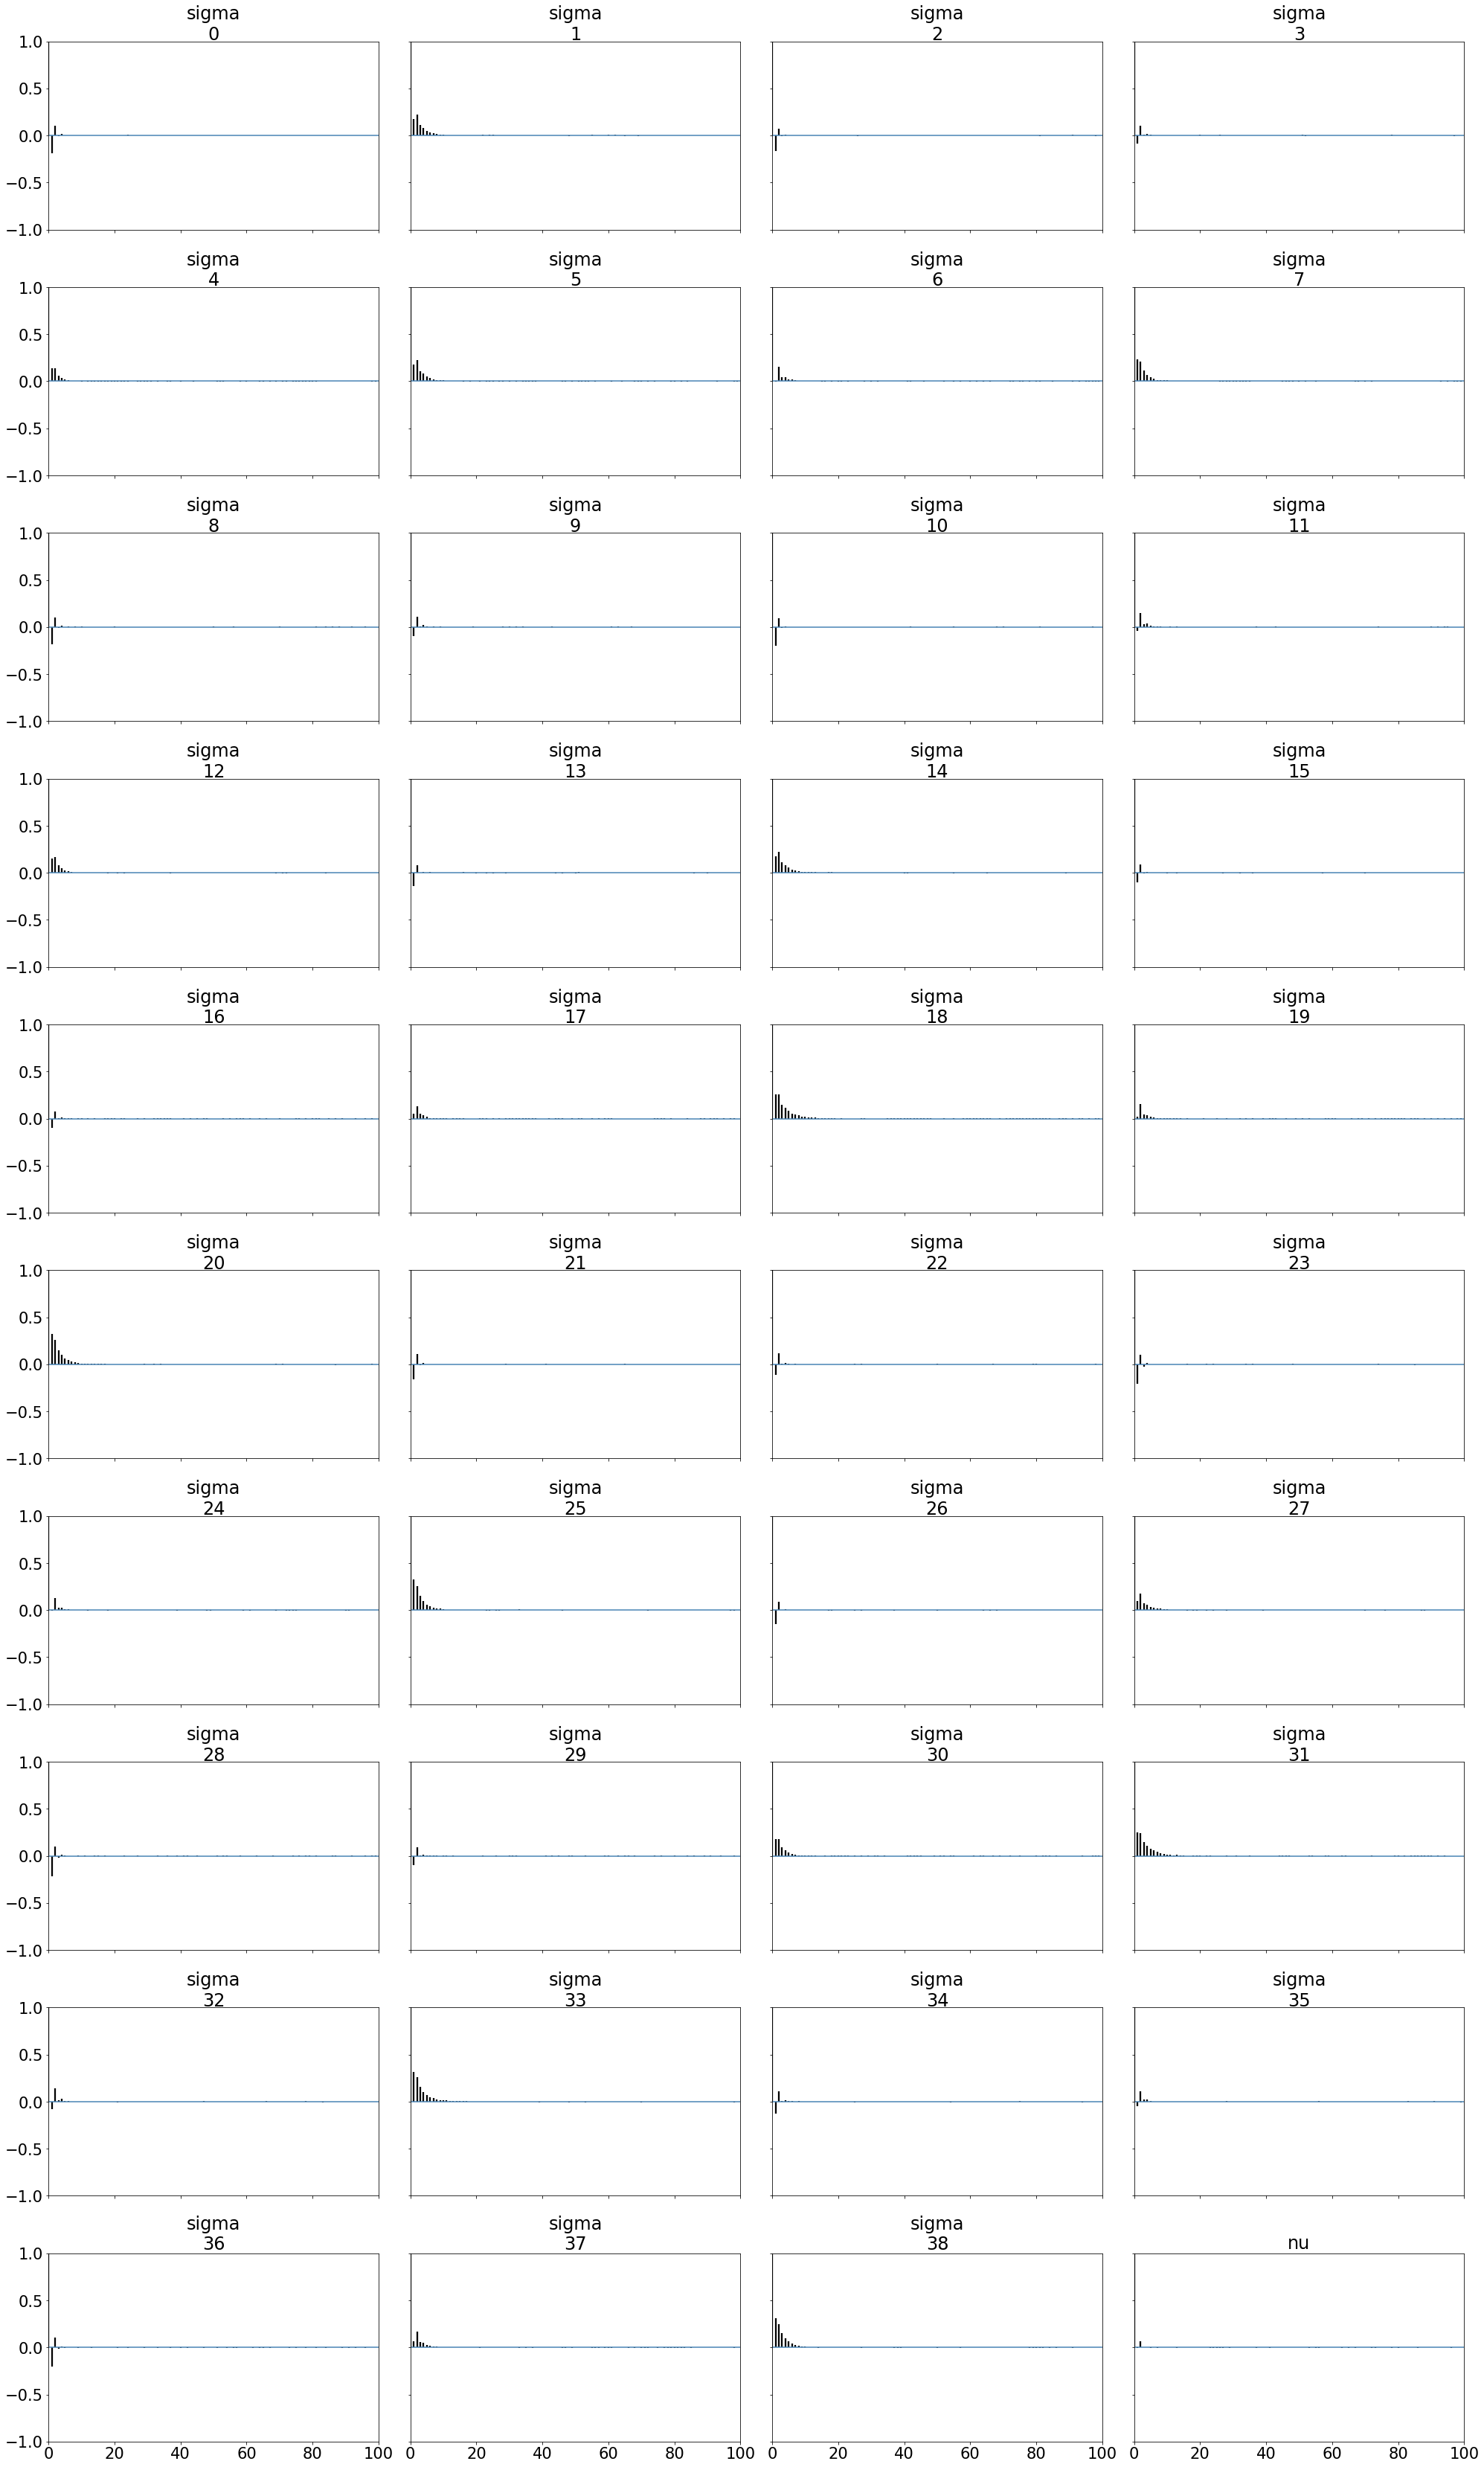

In [26]:
pm.autocorrplot(trace_tb280k, var_names=['sigma', 'nu'], combined=True, textsize=21);

The plots do not indicate any problem, as I expected.<br>

Next I check the sampling summary statistics.

# Sampling summary

In [27]:
pm.summary(trace_tb280k, var_names=['mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],4.021,0.198,3.649,4.398,0.000,0.000,338384.0,338384.0,342731.0,190330.0,1.0
mu[1],4.169,0.550,3.113,5.198,0.001,0.001,175274.0,173809.0,209109.0,140068.0,1.0
mu[2],4.252,0.157,3.952,4.547,0.000,0.000,390176.0,389646.0,393438.0,195473.0,1.0
mu[3],2.710,0.401,1.951,3.467,0.001,0.001,323512.0,315552.0,330717.0,191054.0,1.0
mu[4],3.677,1.549,0.558,6.684,0.003,0.002,215405.0,192779.0,235343.0,162355.0,1.0
mu[5],4.499,0.352,3.847,5.154,0.001,0.001,149877.0,148721.0,212740.0,136946.0,1.0
mu[6],3.944,0.434,3.120,4.760,0.001,0.001,265405.0,265405.0,287521.0,168733.0,1.0
mu[7],2.998,1.284,0.491,5.614,0.003,0.003,144956.0,128370.0,167650.0,128776.0,1.0
mu[8],4.481,0.168,4.167,4.803,0.000,0.000,381889.0,381889.0,390172.0,188791.0,1.0
mu[9],4.028,0.288,3.475,4.567,0.001,0.000,292788.0,292788.0,304674.0,181145.0,1.0


The mcse_mean and mcse_sd values are almost 0. Hence I will have **almost zero standard error** on the posterior mean. Besides, all values of the **r_hat are 1** which is the sign of a **good convergence**. The **effective sample sizes** (ess_bulk) **are large** which **leads to a robust inference** and **highly trusted estimation of HDI**.<br>
Let's check also for 'sigma' and 'nu'.

In [28]:
pm.summary(trace_tb280k, var_names=['sigma', 'nu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.894,0.159,0.623,1.195,0.000,0.000,333257.0,279672.0,398552.0,191241.0,1.0
sigma[1],1.337,0.542,0.568,2.317,0.002,0.001,111890.0,80730.0,204204.0,107224.0,1.0
sigma[2],0.813,0.118,0.606,1.037,0.000,0.000,342690.0,302999.0,394540.0,190899.0,1.0
sigma[3],1.635,0.318,1.104,2.236,0.001,0.000,249523.0,203109.0,342806.0,160240.0,1.0
sigma[4],2.420,1.089,0.758,4.509,0.003,0.002,154946.0,138331.0,181655.0,153040.0,1.0
sigma[5],0.763,0.381,0.304,1.406,0.001,0.001,112956.0,79378.0,229603.0,126297.0,1.0
sigma[6],1.351,0.387,0.752,2.060,0.001,0.001,172853.0,118389.0,287914.0,143347.0,1.0
sigma[7],1.926,1.090,0.464,4.155,0.003,0.002,111316.0,98880.0,142847.0,121461.0,1.0
sigma[8],0.664,0.135,0.438,0.917,0.000,0.000,328278.0,269551.0,418563.0,187569.0,1.0
sigma[9],1.026,0.244,0.626,1.485,0.000,0.000,254643.0,205786.0,335016.0,176561.0,1.0


The same story. Again the mcse_mean and mcse_sd values are almost 0. Hence I will have almost zero standard error on the posterior scale. Anyway, I do not use it for the coming boolean decisions.<br>

Finally, I can test the hypotheses. Before that let's see if the data has outliers.

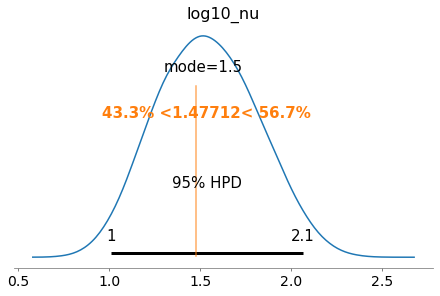

In [29]:
pm.plot_posterior(trace_tb280k, var_names=['log10_nu'], point_estimate='mode', ref_val=np.log10(30), credible_interval=.95);

Its mode is $10^{1.5}  \approx$ 31 hence the data does not have outliers. Since the StudentT distribution essentially is a Normal distribution with normality parameter 'nu' larger than 30.

# Test hypotheses

In [30]:
# I create this list to access the index of the communities easily
c = ['Apache_P', 'Coala_P', 'FOSSASIA_P', 'Linux_Kernel_P', 'Mozilla_P', 'NodeJS_P', 'Odoo_P', 'OpenGenus_P', 
     'OpenSUSE_P', 'Plone_P', 'ROS_P', 'ReactJS_P', 'jQuery_P',
     'Apache_E', 'Coala_E', 'FOSSASIA_E', 'Linux_Kernel_E', 'Mozilla_E', 'NodeJS_E', 'Odoo_E', 'OpenGenus_E', 
     'OpenSUSE_E', 'Plone_E', 'ROS_E', 'ReactJS_E', 'jQuery_E',
     'Apache_L', 'Coala_L', 'FOSSASIA_L', 'Linux_Kernel_L', 'Mozilla_L', 'NodeJS_L', 'Odoo_L', 'OpenGenus_L', 
     'OpenSUSE_L', 'Plone_L', 'ROS_L', 'ReactJS_L', 'jQuery_L']

Specifying the Region of Practical Equivalence (ROPE) is not always simple and need domain knowledge. ±0.1 can be used to determine the ROPE limits in general. Nevertheless, I define ROPE ±0.2 as it makes more sense in this analysis.

# H1: The Coala Community is more lenient than the Linux Kernel Community.

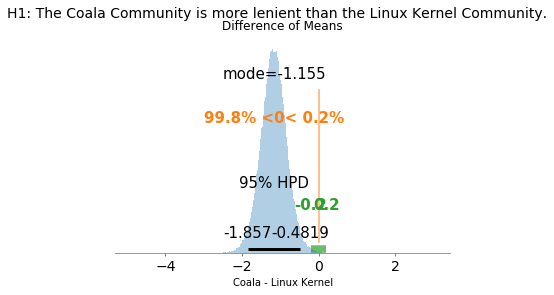

In [31]:
fig, ax = plt.subplots()
fig.suptitle('H1: The Coala Community is more lenient than the Linux Kernel Community.', fontsize='14')

pm.plot_posterior( trace_tb280k['mu'][:,c.index('Coala_L')] - trace_tb280k['mu'][:,c.index('Linux_Kernel_L')],
         ax=ax, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2))
ax.set_title("Difference of Means")
ax.set_xlabel("Coala - Linux Kernel");

The above posterior plot suggests that Coala Community is not more lenient than the Linux Kernel Community even though with ROPE ± 0.2. Therefore, I **reject this hypothesis (H1)**. The reason that I reject it is, the 95% HDI (same as HPD) falls on the left side of the null hypothesis and is not touching the ROPE.

# H2: All communities show either a protective or equitable style of governance for pull requests
(so for each community answers to V29 and V31 are different).

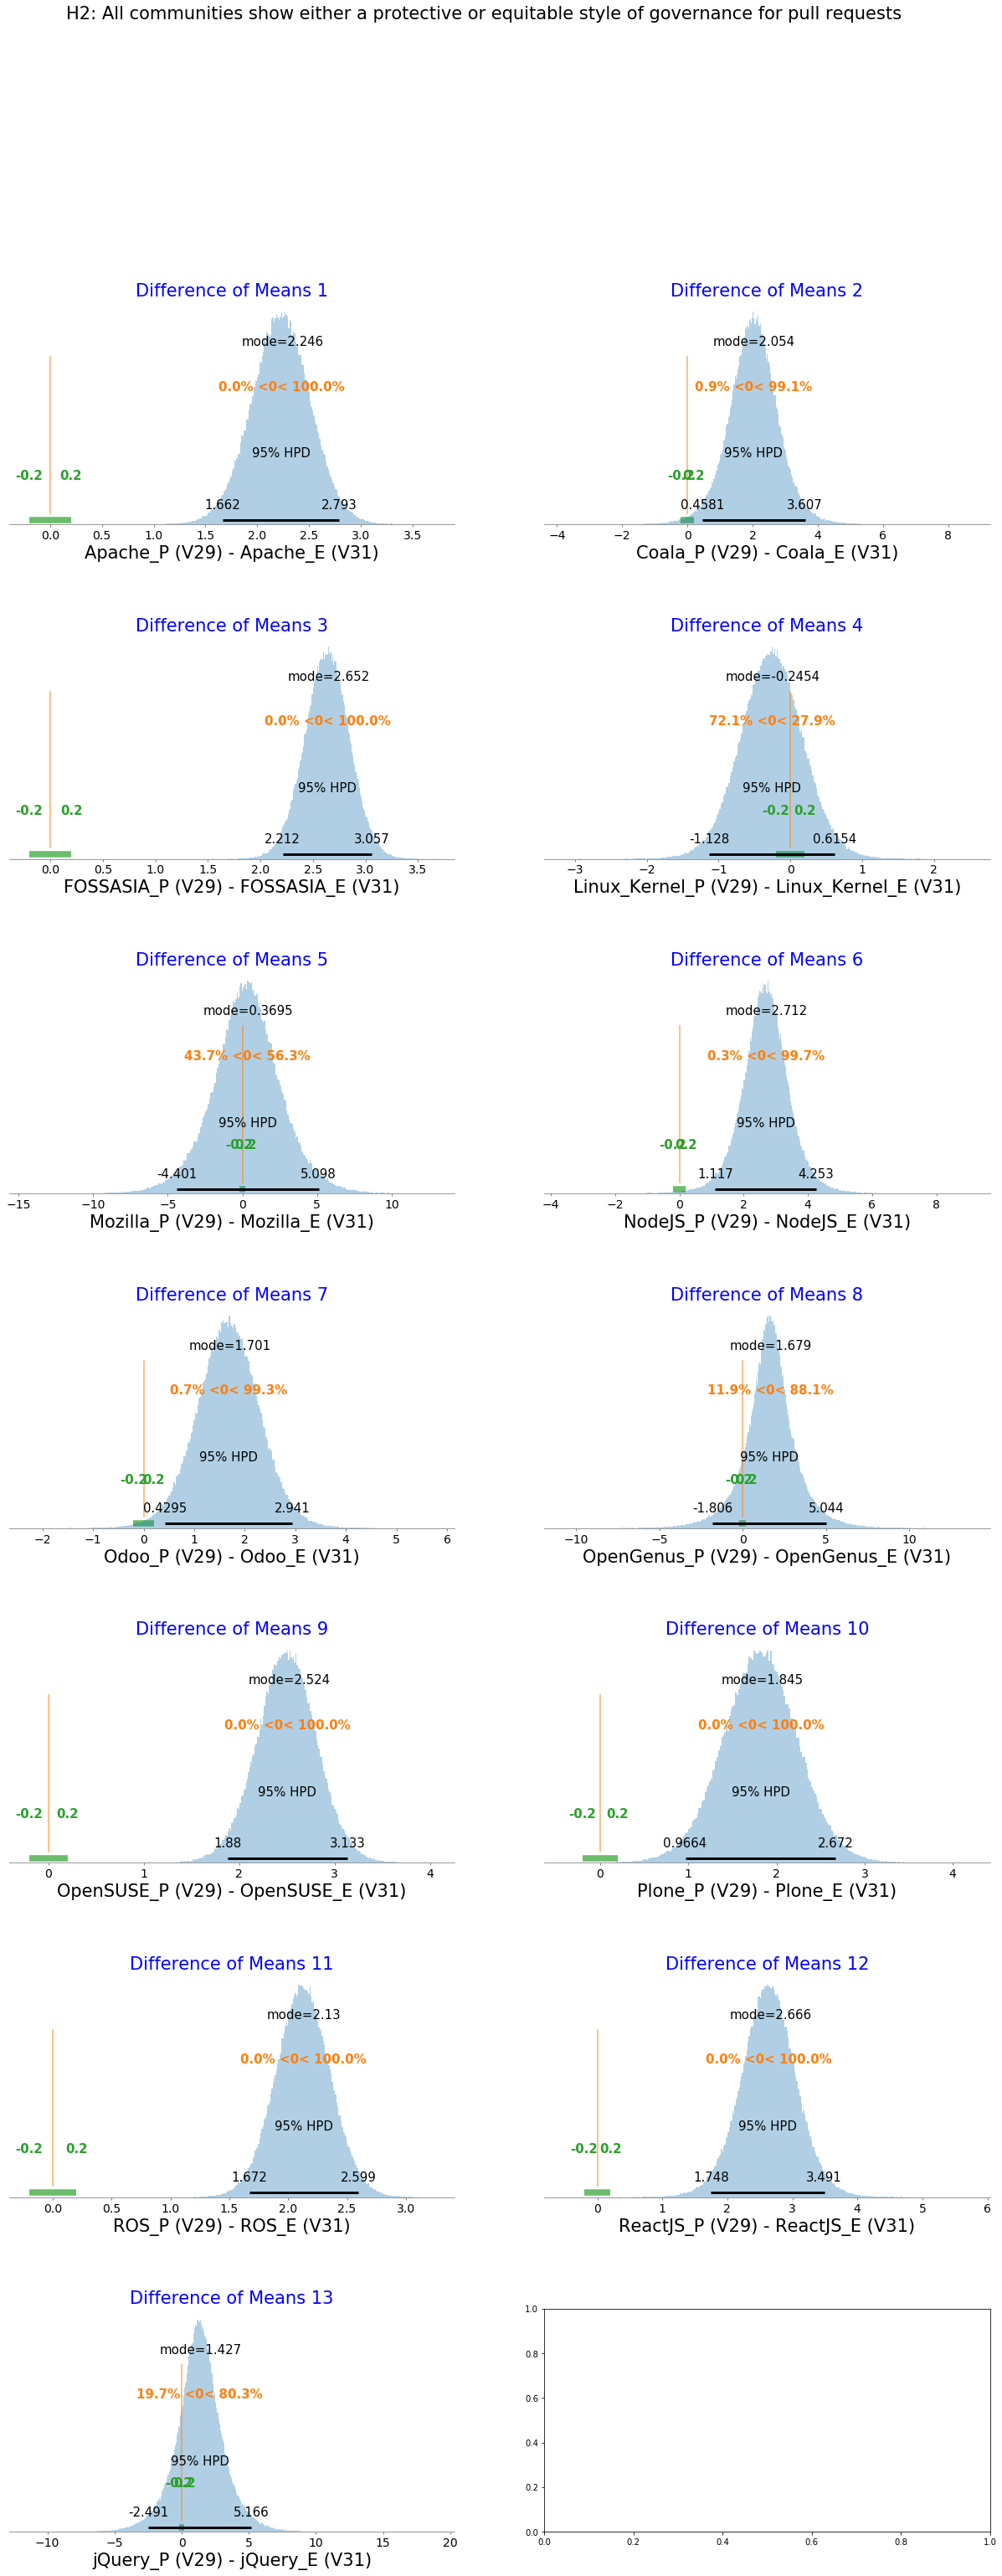

In [32]:
fig, ax = plt.subplots(7,2, figsize=(21,49))
fig.subplots_adjust(hspace = 0.5) 
fig.suptitle('H2: All communities show either a protective or equitable style of governance for pull requests', fontsize='21')
# A helper function to plot the difference between two given communities
def plot_dif(trace, p, C1, C2, ax, i):
    
    pm.plot_posterior( trace['mu'][:,c.index(C1)] - trace['mu'][:,c.index(C2)],
         ax=ax, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.2,+0.2))
    ax.set_title(f"Difference of Means {i}", fontdict={'fontsize':21, 'color': 'b'})
    ax.set_xlabel(f"{C1} (V29) - {C2} (V31)", fontdict={'fontsize':21})

plot_dif(trace_tb280k, 'mu', 'Apache_P', 'Apache_E', ax[0,0], 1)
plot_dif(trace_tb280k, 'mu', 'Coala_P', 'Coala_E', ax[0,1], 2)
plot_dif(trace_tb280k, 'mu', 'FOSSASIA_P', 'FOSSASIA_E', ax[1,0], 3)
plot_dif(trace_tb280k, 'mu', 'Linux_Kernel_P', 'Linux_Kernel_E', ax[1,1], 4)
plot_dif(trace_tb280k, 'mu', 'Mozilla_P', 'Mozilla_E', ax[2,0], 5)
plot_dif(trace_tb280k, 'mu', 'NodeJS_P', 'NodeJS_E', ax[2,1], 6)
plot_dif(trace_tb280k, 'mu', 'Odoo_P', 'Odoo_E', ax[3,0], 7)
plot_dif(trace_tb280k, 'mu', 'OpenGenus_P', 'OpenGenus_E', ax[3,1], 8)
plot_dif(trace_tb280k, 'mu', 'OpenSUSE_P', 'OpenSUSE_E', ax[4,0], 9)
plot_dif(trace_tb280k, 'mu', 'Plone_P', 'Plone_E', ax[4,1], 10)
plot_dif(trace_tb280k, 'mu', 'ROS_P', 'ROS_E', ax[5,0], 11)
plot_dif(trace_tb280k, 'mu', 'ReactJS_P', 'ReactJS_E', ax[5,1], 12)
plot_dif(trace_tb280k, 'mu', 'jQuery_P', 'jQuery_E', ax[6,0], 13)

I **neither accept nor reject this hypothesis (H2)**. The reason is, the ROPE and 95% HDI overlap in plots 4, 5, 8, and 13 so not all communities show either a protective or equitable style of governance for pull requests.

# Conclusion
By making a boolean decision I am doing a huge oversimplification of the outcome of Bayesian inference. 
Looking at the digraph of the model or the data plots one can realize that some communities have more responses than the rest. The inference would be more stable if the communities had the same number of responses. That is, it is not so fair to compare two communities with huge different data points. On the other hand, more than half of the data are not used in the inference since most interviewees (the member of the communities) did not participate in the survey. It would be great If they somehow encourage the interviewees to get involved in and collect more data and then make the inference. It is totally allowed in Bayesian inference and is where it shines.